## Araçların Yakıt Tüketimi Tahmini

Araçların ne kadar yakıt tükettiklerinin tahminlemesini yapacağımız algoritma geliştireceğiz.

Bu amaç için gerçekleştirilecek adımlar sırasıyla şu şekildedir:

<br>
<img src="a1.png" style="width:800px;height:200px"/><br> 

### Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats #skewness değeri bulmak için
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# warning 
import warnings
warnings.filterwarnings('ignore')

C:\Users\raziy\anaconda3\envs\tk\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Araçların bazı özelliklerine göre aracın tükettiği yakıt miktarına dair tahmin yapacağız. Kullanacağımız feature'lerden bahsedeyim.

1. mpg: continuous bir feature'dir. Bir galon benzinle veya mazotla kaç mil gittiğini gösteren ölçümdür. Yani 100 kilometrede ne kadar gittiği gibi düşünebiliriz.

2. cylinders: multi-valued discrete. Motor içinde bulunan silindir sayısıdır. 4 ile 8 arasında değişmektedir.

3. displacement: continuous. Motorun kaç inç olduğudur.

4. horsepower: continuous. Motorun beygir gücüdür.

5. weight: continuous. Araç ağırlığıdır.

6. acceleration: continuous. Hızlanmadır.

7. model year: multi-valued discrete. Aracın ne zaman üretildiğidir.

8. origin: multi-valued discrete. Aracın kökenidir. Amerika, Avrupa ve Japonya vardır.

9. car name: string (unique for each instance). Araçların isimleridir.

Bu 8 feature'yi kullanarak yakıt tüketiminin ne olduğunu tahminlemeye çalışacağız.

Şimdi data'yı import edelim.

In [2]:
column_name = ["MPG", "Cylinders", "Displacement","Horsepower","Weight","Acceleration","Model Year", "Origin"]
data = pd.read_csv("auto-mpg.data", names = column_name, na_values = "?", comment = "\t",sep = " ", skipinitialspace = True)

data = data.rename(columns = {"MPG":"target"})

print(data.head())
print("Data shape: ",data.shape)


   target  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  
Data shape:  (398, 8)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


Çıktıda "3   Horsepower    392 non-null    float64" satırından anlaşılacağı üzere 6 tane missing value vardır.

In [4]:
describe = data.describe()
describe

,target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


50% median değeridir. median ile mean değeri aynı değil ise, mean değeri median değerinden daha büyük ise gaussian dağılıma (normal dağılıma) sahip bir data diyemeyiz. Eğer normal dağılıma sahip olsaydı mean ve median değerleri aynı olurdu. Fakat mean değeri biraz daha sağ taraftadır. Mean değeri median değerinden büyük olduğu için bu sola doğru yatmıştır yani sağa doğru kuyruğu olan positive skewness'a sahip bir datadır.

### Imputing Missing Value (Kayıp Veri Sorunu)

Missing value'leri data'dan çıkarmak bir çözüm değildir. Çünkü data'nın dengesini bozabiliriz ve veri kaybına sebep olabiliriz. Bu nedenle missing value'leri handle etmeliyiz.

target          0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
target          0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


<AxesSubplot:xlabel='Horsepower', ylabel='Density'>

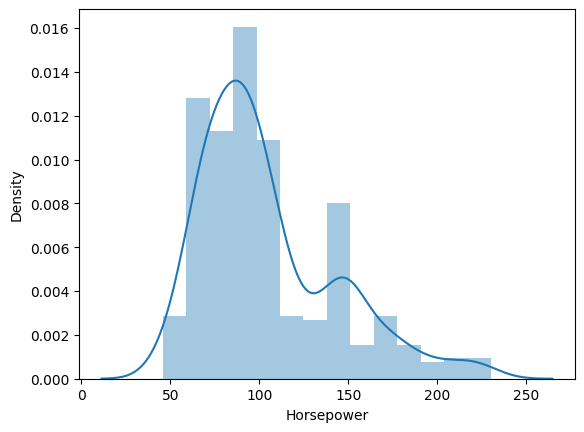

In [5]:
# missing value
print(data.isna().sum())

data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())

print(data.isna().sum())

sns.distplot(data.Horsepower)

Yukarıdaki kod bloğu ile Horsepower feature'sindeki missing value'ler Horsepower feature'sinin mean değeri ile doldurulmuştur. Böylelikle missing value problemi çözülmüştür.

### Keşifsel-Açıklayı Veri Analizi (Exploratory Data Science)

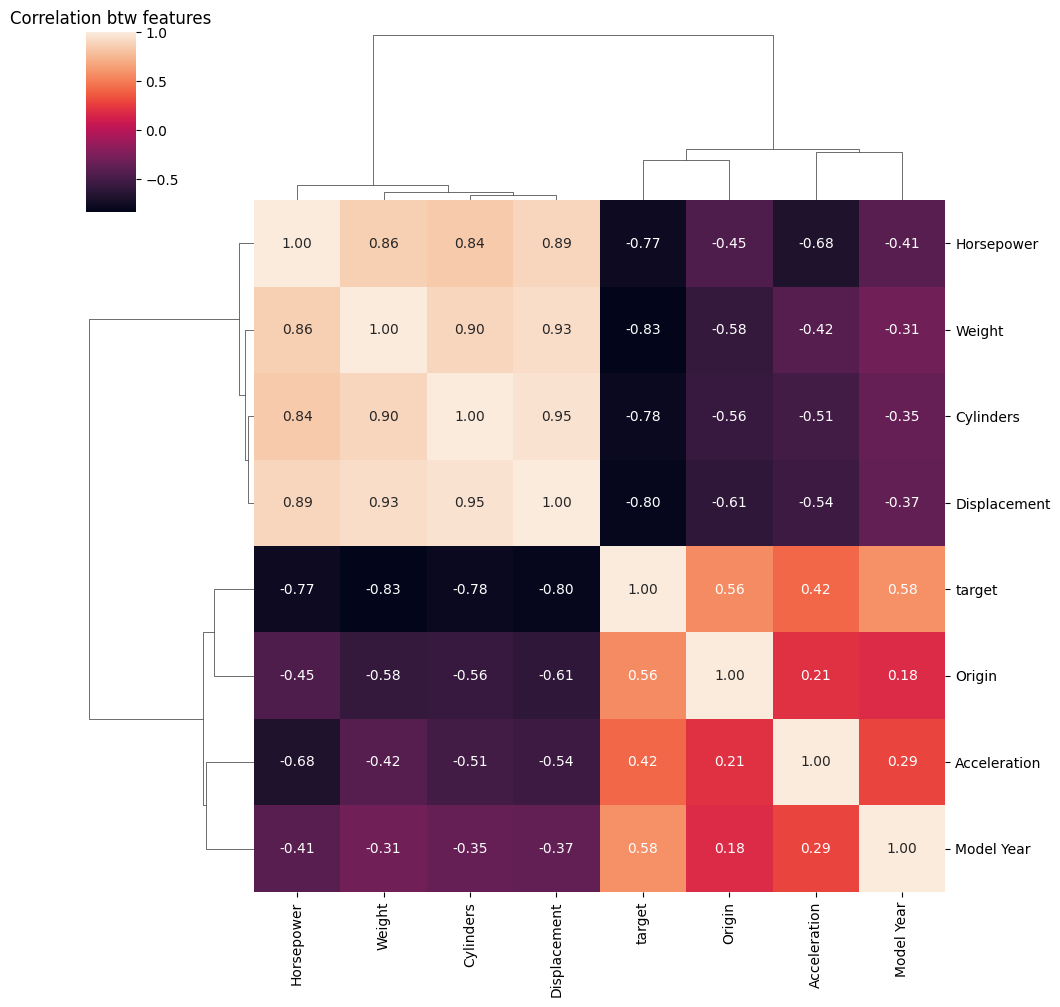

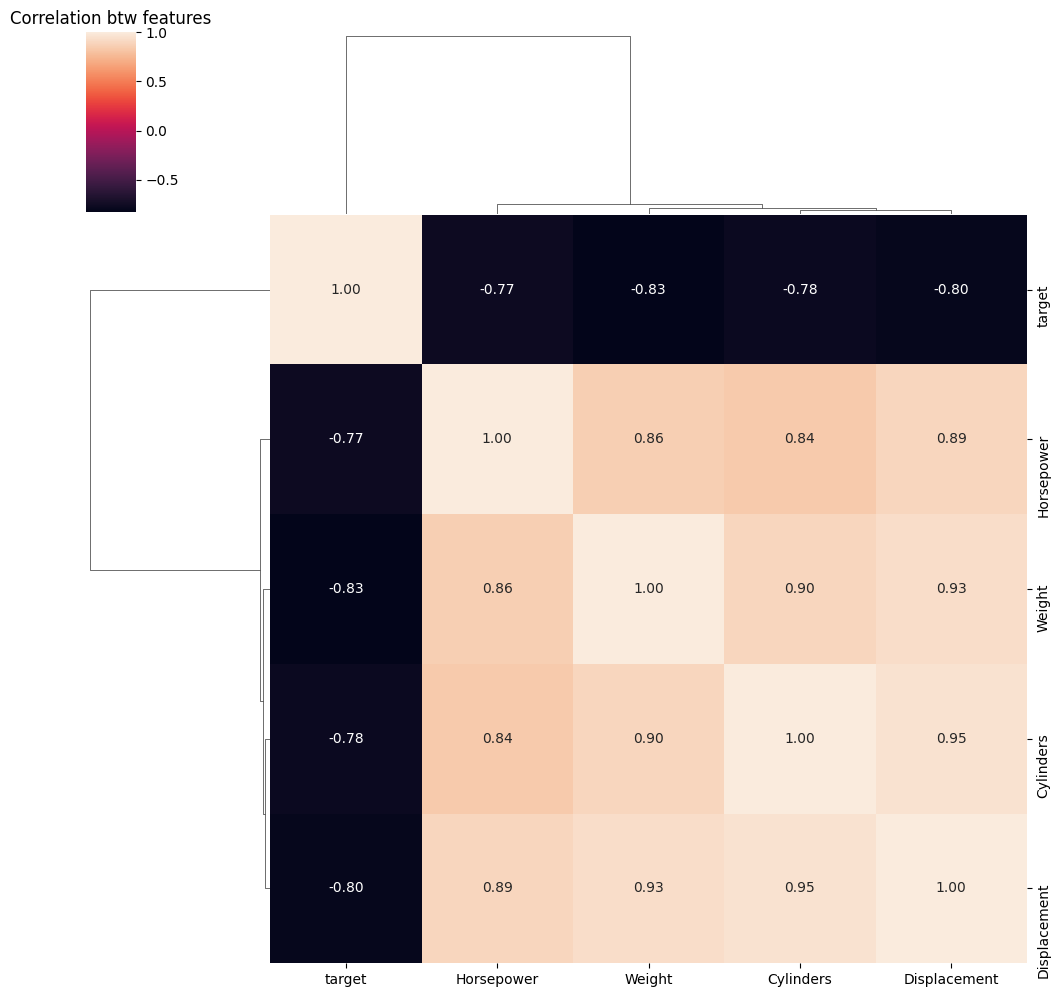

In [6]:
# EDA

corr_matrix = data.corr()  
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation btw features")
plt.show()

#Korelasyon değeri 0.75'den büyük olan feature'ler görselleştirilmiştir.
threshold = 0.75
filtre = np.abs(corr_matrix["target"])>threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation btw features")
plt.show()

Numeric feature'ler var ise olmazsa olmaz işlemlerden birisi feature'ler arasındaki korelasyona bakmaktır. Bu işlem

corr_matrix = data.corr()  

sns.clustermap(corr_matrix, annot = True, fmt = ".2f")

plt.title("Correlation btw features")

plt.show()

satırlarında gerçekleştirilmiştir.

threshold = 0.75

filtre = np.abs(corr_matrix["target"])>threshold

corr_features = corr_matrix.columns[filtre].tolist()

sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")

plt.title("Correlation btw features")

plt.show()

satırlarında ise Korelasyon değeri 0.75'den büyük olan feature'ler görselleştirilmiştir.

❗Birbirleri ile yüksek ilişkiye sahip feature'ler var ise bu feature'ler birbirileri ile eş düzlemdir diyebiliriz. Yani bunlar arasında multicollinearity vardır. Bu durum bizim için dezavantajdır. Çünkü multicollinearity birbirleriyle ilişkili birden çok feature'nin yani 1 tane feature kullanmak yerine 5 tane feature aynı şeyi söylüyorsa bu bizim modelimizi yanlış yönlendirebilir. 1 tanesi yetiyor ise 5 tanesi ile uğraşmamıza gerek yoktur.

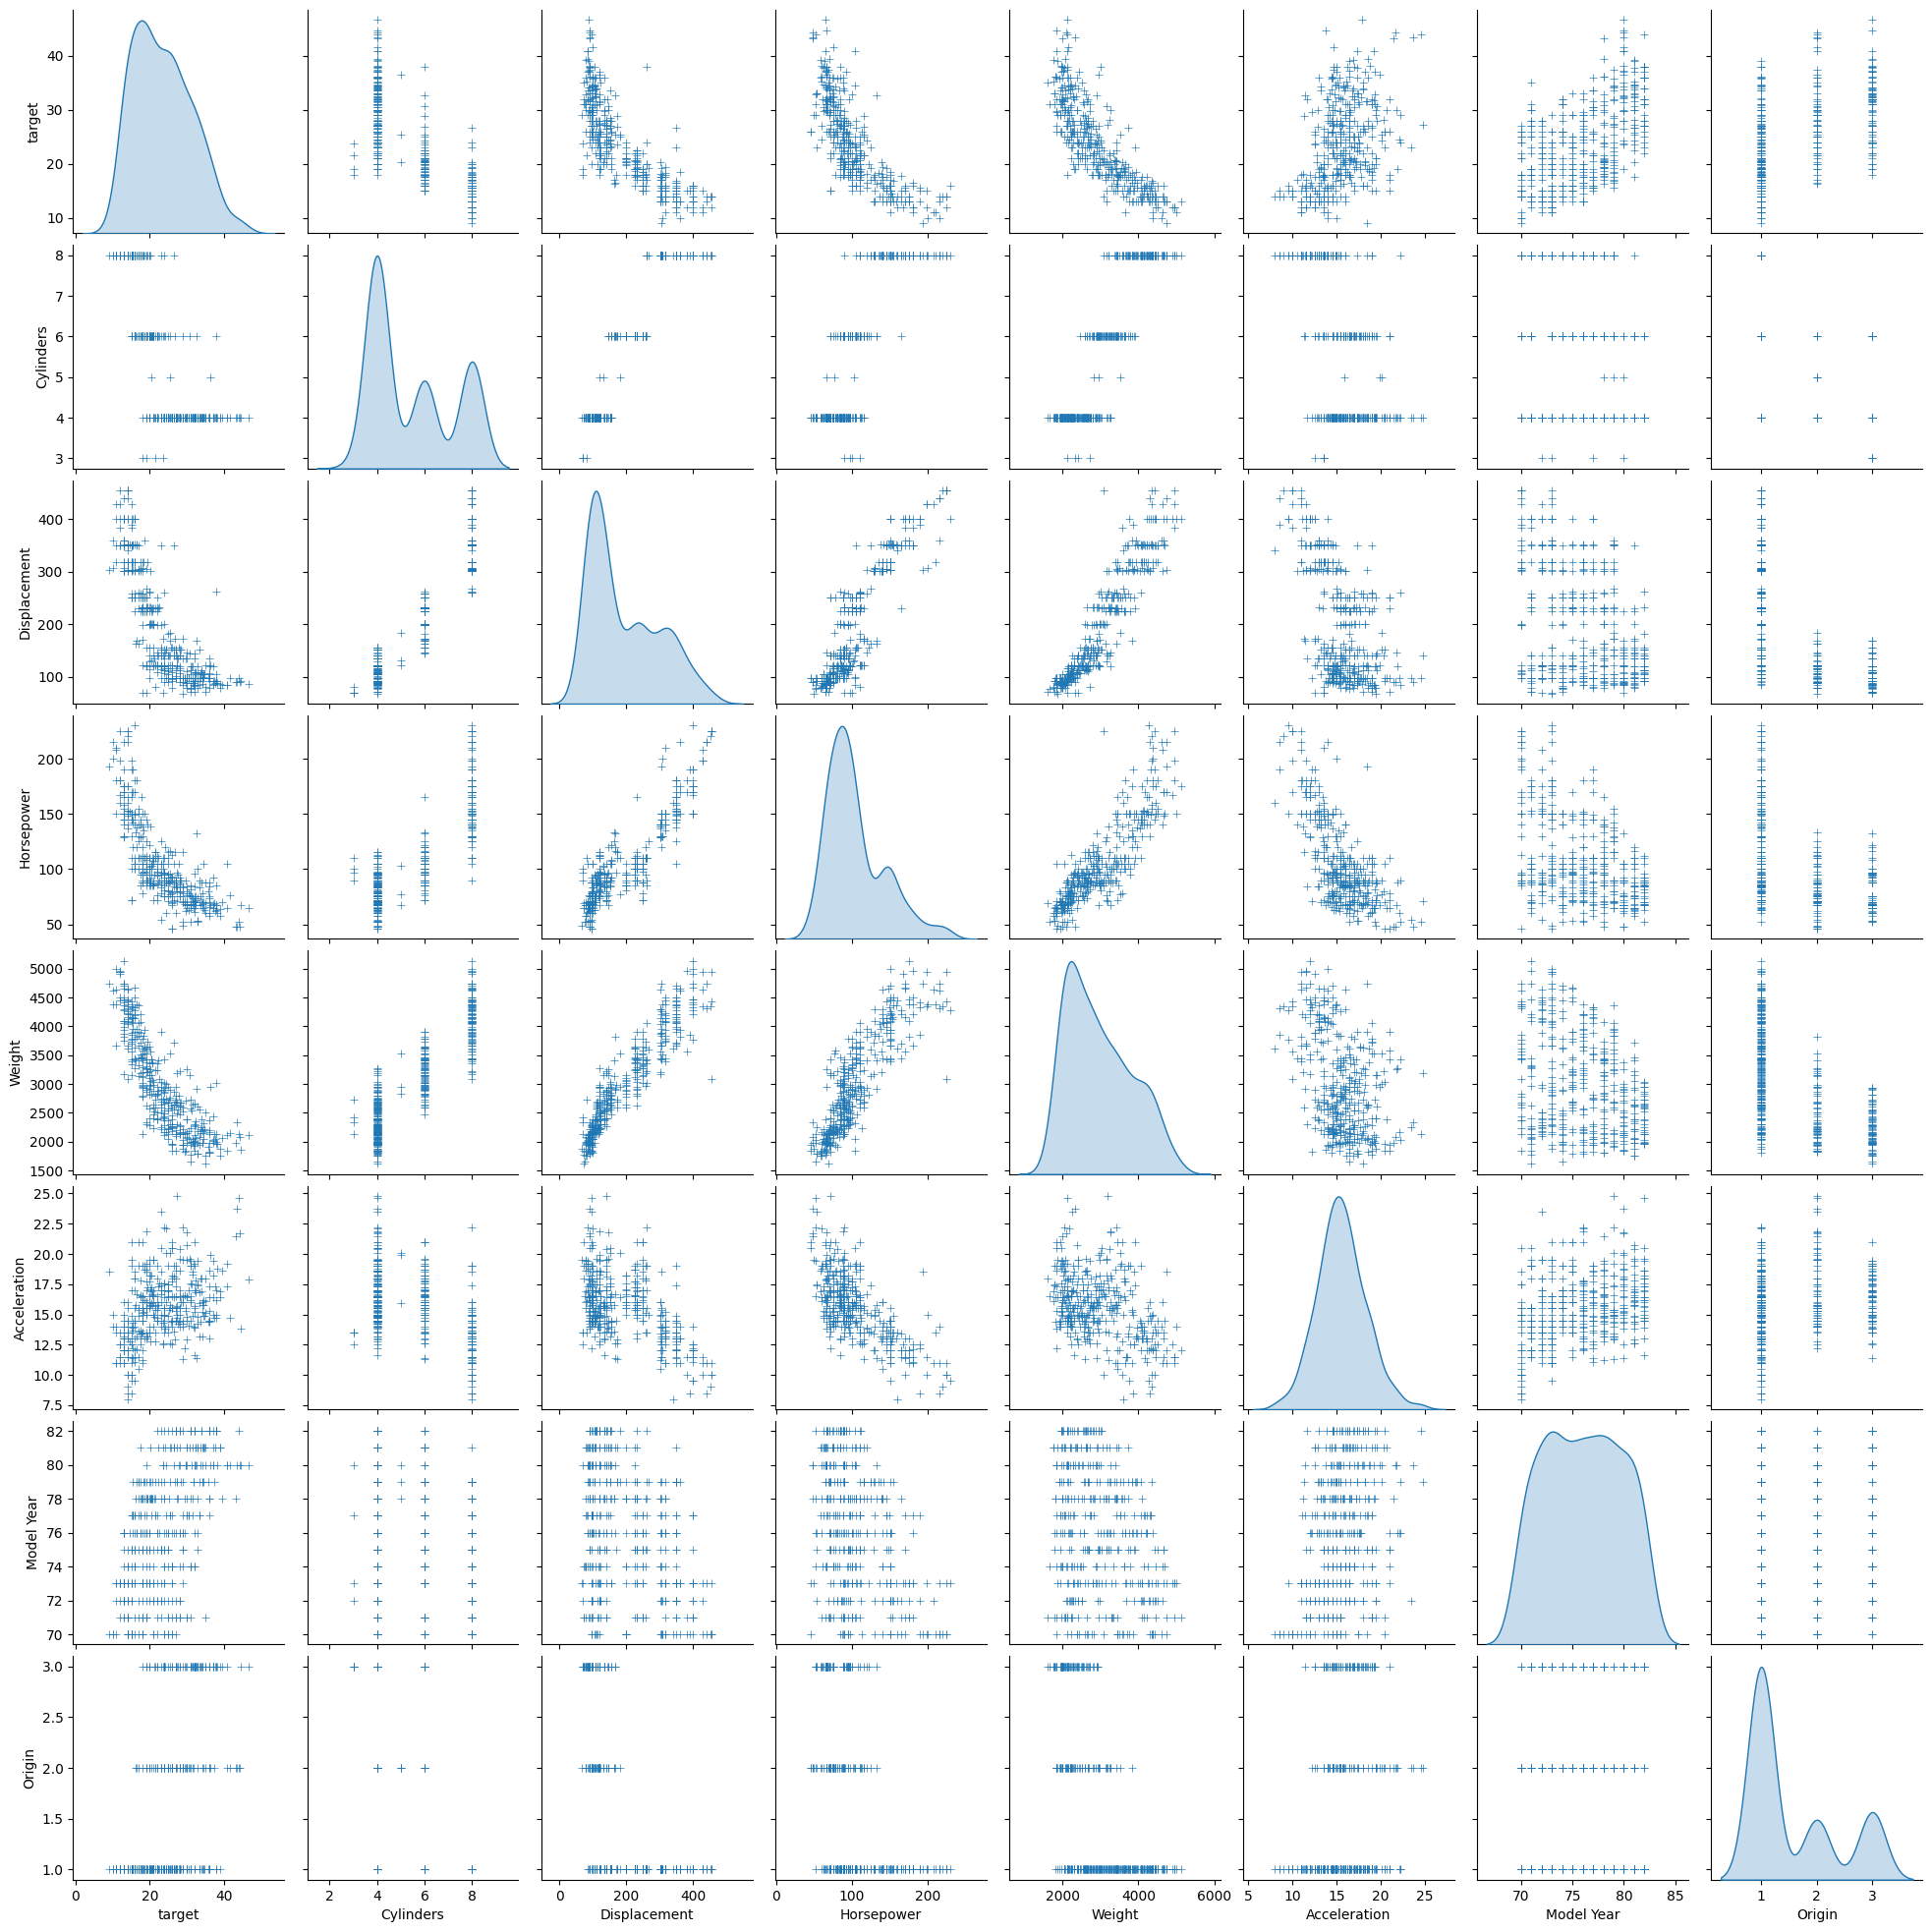

In [7]:
sns.pairplot(data, diag_kind = "kde", markers = "+")
plt.show()

Yukarıda pairplot ile tüm feature'lere göz atılmıştır.

cylinders and origin can be categorical (feature engineering).

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64
1    249
3     79
2     70
Name: Origin, dtype: int64


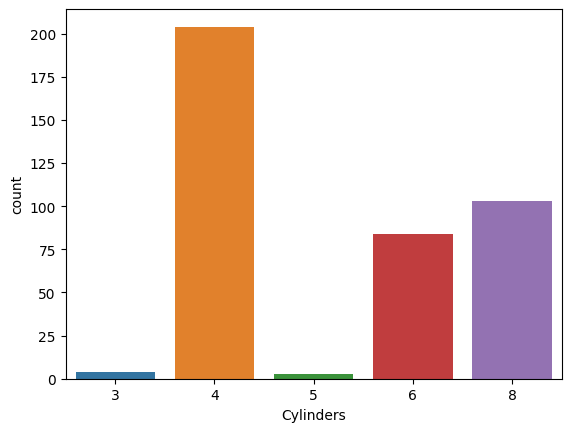

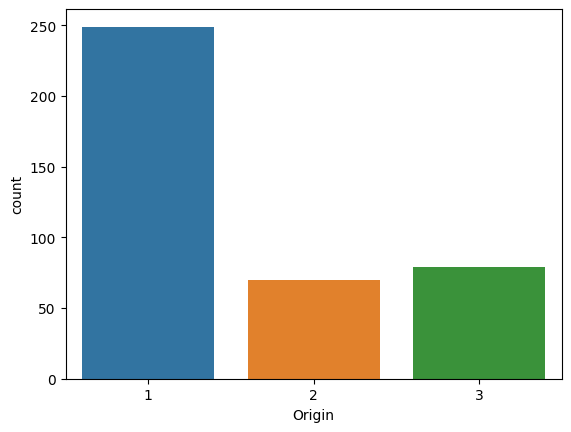

In [8]:
plt.figure()
sns.countplot(data["Cylinders"])
print(data["Cylinders"].value_counts())

plt.figure()
sns.countplot(data["Origin"])
print(data["Origin"].value_counts())

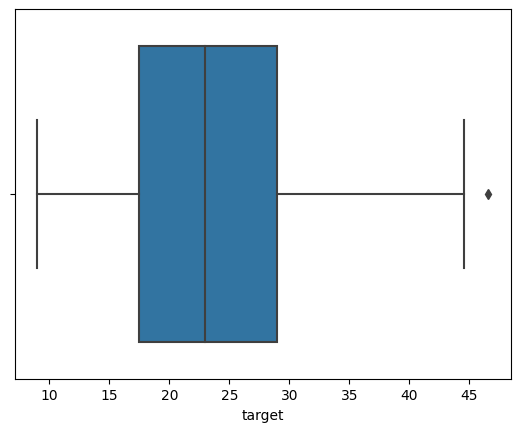

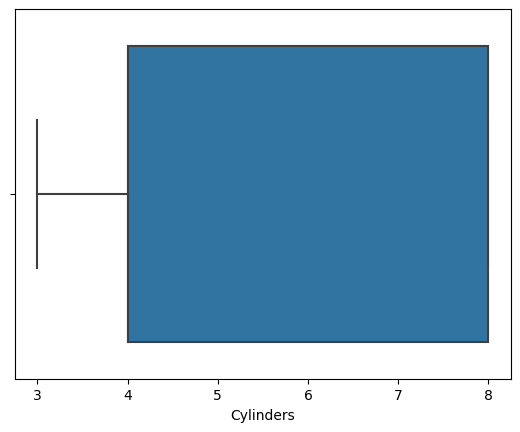

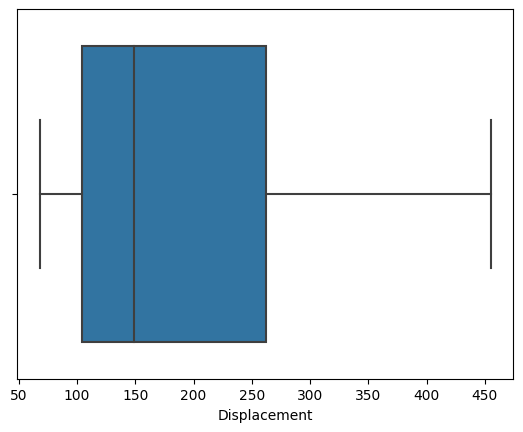

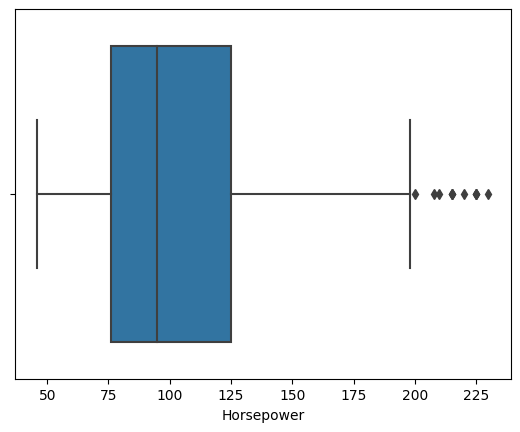

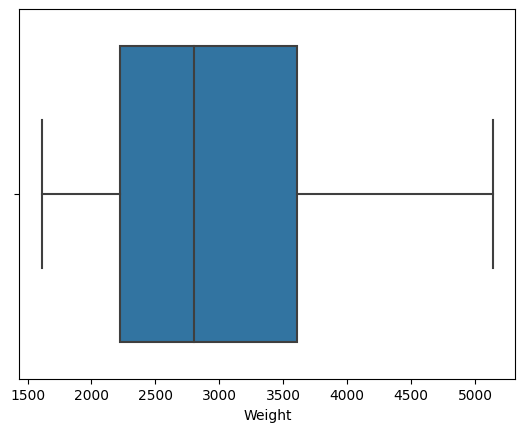

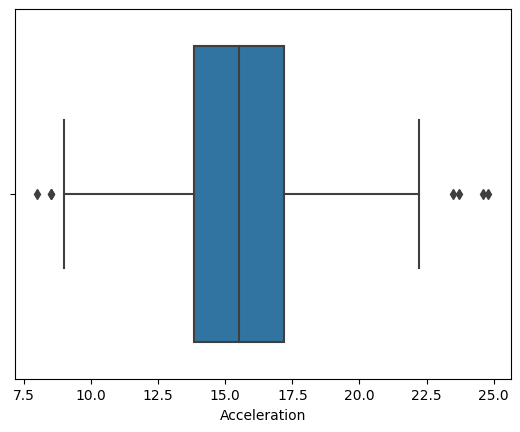

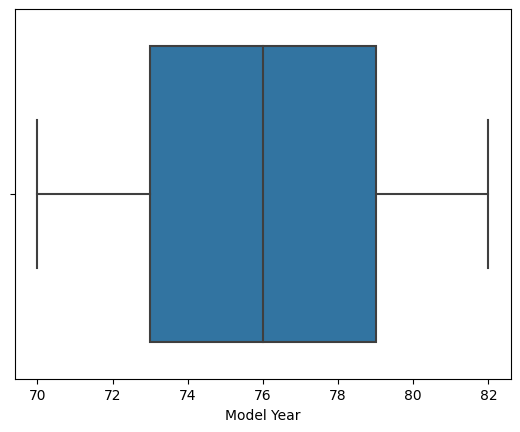

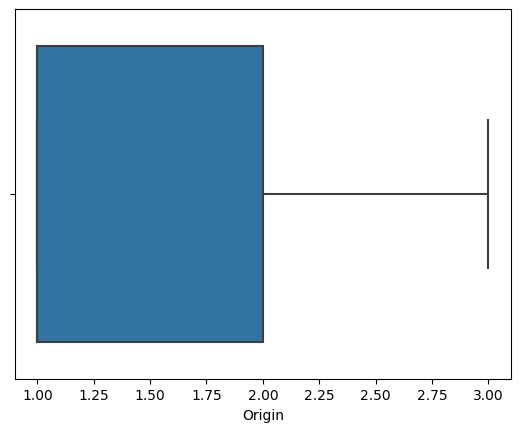

In [9]:
# box
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "v")

Yukarıda outlier'lara bakabilmek için box plot çizilmiştir. Dikdörtgen ortasındaki çizgi median'dır.

En üst ve en alt çizgilerin dışında kalan noktalar outlier'lardır.

### Outlier'ların Tespiti ve Çıkarılması

horsepower ve acceleration feature'lerinde outlier değerler bulunmaktadır ve dolayısıyla horsepower ve acceleration feature'lerindeki outlier değerleri çıkaralım. Çıkarma sebebimiz, outlier (aykırı değerler) veriyi bozuyor ve modelin veriyi düzgün bir şekilde fit etmesini engelliyor.

<br>
<img src="a2.png" style="width:800px;height:400px"/><br> 

In [10]:
thr = 2
horsepower_desc = describe["Horsepower"]
q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data["Horsepower"]
filter_hp_top = data["Horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]

acceleration_desc = describe["Acceleration"]
q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc # q3 - q1
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data["Acceleration"]
filter_acc_top= data["Acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc] # remove Horsepower outliers

### Feature Engineering (Öz Nitelik Mühendisliği): Skewness

Skewness: Normal dağılıma göre çarpıklıktır.

Normal dağılımda mean, median ve mode değerlerinin herpsi birbirine eşittir ve mean etrafında simetrik yapıya sahiptirler.

Skewness ise, eğğer normal yapıya göre ssağa doğru veya sola doğru kuyruğu olan yapılara Skewed data denir. Eğer kuyruk sağa doğru ise Right skewed veya positive skewed olarak adlandırılır. Eğer kuyruk sola doğru ise Left skewed veya negative skewed olarak adlandırılır.

Verinin 3.momenti skewness değerini verir. 

Verinin 1.momenti mean, 2.momenti standart sapmayı verir.

Skewness değeri 1'den büyük ise positive skewness vardır. Eğer 1'den küçük ise negative skewness vardır.

Bahsedilen kuyruk, outlier olarak nitelendirilebilir ve modeli olumsuz etkiler. Dolayısıyla çarpık (skewness) verileri gaussian dağılımına doğru evritmemiz gerekiyor, yani çarpıklıklarını azaltmamız gerekiyor. Buda modelin daha iyi çalışmasını sağlamaktadır.

Log dönüşümü ile yüksek eğilimli dağılımları düşük eğilimli dağımlara çevirebiliyoruz yani skewness değerini azaltabiliyoruz.

mu: 23.472405063291134, sigma = 7.756119546409932


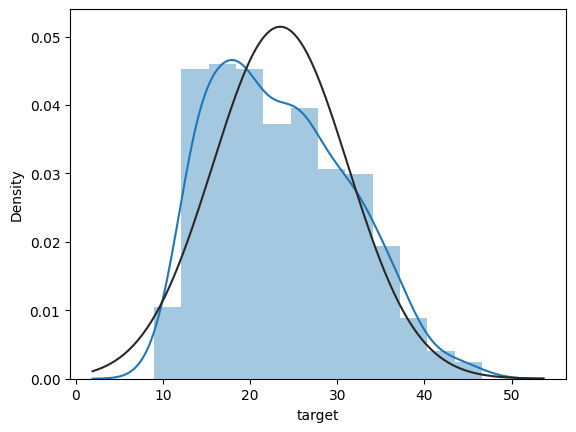

In [11]:
# Feature Engineering
# Skewness

# target dependent variable
sns.distplot(data.target, fit = norm)

(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

Data'nın target'ının dağılımı incelenmiştir. 

Çıktıdaki normal dağılım siyah line dır. Kendi datamız ise mavi line dır.

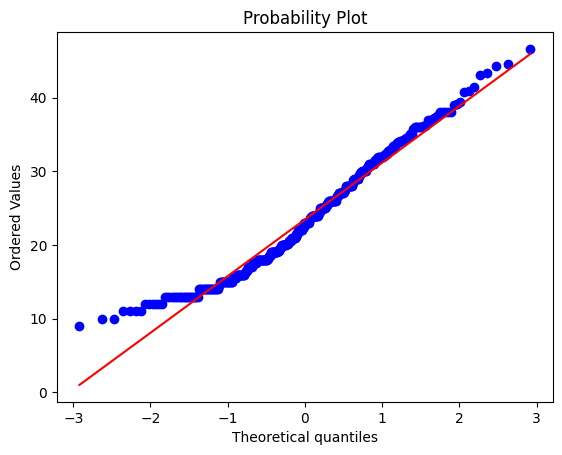

mu: 3.146474056830183, sigma = 0.3227569103044823


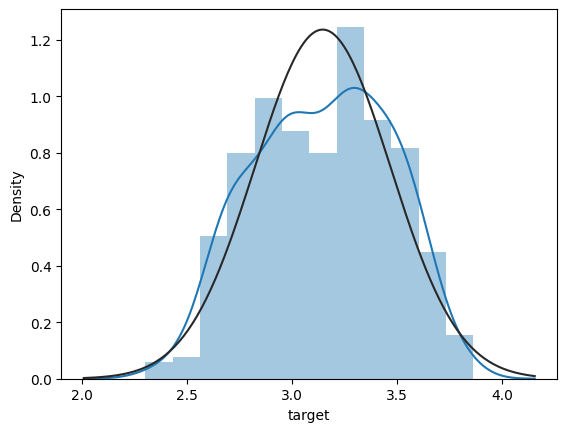

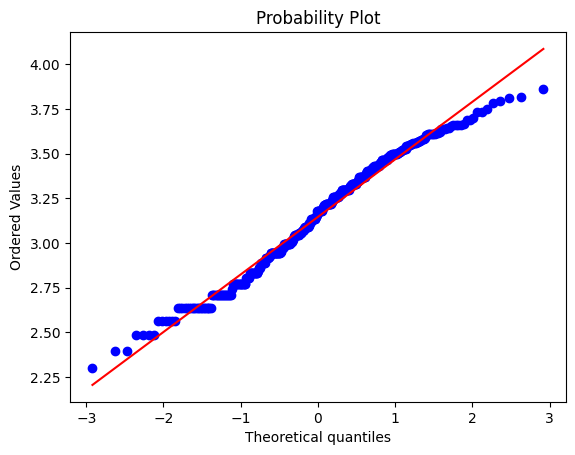

In [12]:
# qq plot
plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

data["target"] = np.log1p(data["target"]) 

plt.figure()
sns.distplot(data.target, fit = norm)

(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

# qq plot
plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

Dağılımın ne kadar gaussian dağılım(normal dağılım) olup olmadığını qq plot ile inceledik.

Ordered values, data'nın quantile değerleridir. Theoretical quantiles ise normal dağılıma ait quantile'lardır. Mavi kendi data'mızdır.

data["target"] = np.log1p(data["target"]) satırında skewness'lik değerini azaltabilmek için log transform gerçekleştirilmiştir.

Şimdi feature'lerin independet değerlerine bakalım.

In [13]:
# feature - independent variable 
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
Horsepower,1.067743
Origin,0.923381
Displacement,0.714682
Weight,0.533226
Cylinders,0.523374
Acceleration,0.168986
Model Year,0.013098
target,-0.117687


❗Herhangi bir null değeir var ise skewness'i etkiler ve eğer null değeri olsaydı bunu kaldırmamız gerekecekti.

Çıktıda görüldüğü üzere Horsepower'da 1.06'lık bir skewness değeri vardır. Yani positive skewness vardır. bunu düzeltmeye gerek yoktur çünkü 106 değeri 1'e çok yakın ve bunu ihmal edebiliriz.

Ayrıca şunuda söylemeliyim ki, skewness feature'leri düzeltmek istersek Box Cox transformation yöntemi ile bu işlemi yapabiliriz.

### Feature Engineering (Öz Nitelik Mühendisliği): One Hot Encoding

Mesela origin feature'si numeriz olmasına rağmen categorical olarak değerlendirip one hot encoding yapalım. Origin feature'si 1,2 ve 3 değerlerine sahiptir. One hot encoding işlemini uyguladıktan sonra origin feature'si ortadan kalkıyor ve origin1, origin2, origin3 şeklinde 3 tane feature oluşuyor. 

<br>
<img src="a3.png" align="left" style="width:300px;height:200px"/><br>   

0 değeri, 1 değeri ve 2 değerinin origin feature'lerindeli gösterimi sırasıyla yukarıda görülmektedir. Yani encoding hallerini yukarıda görmektesiniz.

Peki encoding işlemi neden yapılmaktadır?: Encoding işlemi yapmazsak categorical veriler modelimizi bozucaktır.

In [14]:
# %% one hot encoding
data["Cylinders"] = data["Cylinders"].astype(str)  
data["Origin"] = data["Origin"].astype(str) 

data = pd.get_dummies(data)

get_dummies metodu ile data içerisinde bulunan categorical feature'leri one hot encoding yapacaktır. Fakat data içerisinde categorical feature yoktur. Dolayısıyla öncelikle Cylinders ve Origin feature'leri categorical hale getirilmiştir. Origin ve Cylinder feature'leri kalkarak, Origin1, Origin2, Origin3 ve Cylinders3, Cylinders4, Cylinders5, Cylinders6, Cylinders8 feature'leri gelmiştir. Cylinders içerisindeki değerler 3,4,5,6,8 değerleri olduğu için feature isimlerinin sonundaki sayılar bu şekildedir.

### Preprocess: Eğitim/Test Verisinin Ayrılması ve Standardizasyon

In [15]:
# %% Split - Standaedization

# Split
x = data.drop(["target"], axis = 1)
y = data.target

test_size = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = test_size, random_state = 42)

# Standardization
scaler = RobustScaler()  # RobustScaler #StandardScaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression (Doğrusal Regresyon)

Linear regression, dependent variable (y) ile independet variable (x yani feature'ler) arasında line fit etmeye yarayan yöntemdir. Bu line'a regression line denir. Bu line'ı bulmak için kullanılan yönteme mean square yöntemi denir. Amacımız, mean square error'u minimize etmektir.

Linear regression'un amacı en küçük error değerine sahip line'ı fit etmeye çalışmaktır.

<br>
<img src="a4.png" align="left" style="width:500px;height:400px"/><br>   

In [16]:
# Regression Models

# linear regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
print("LR Coef: ",lr.coef_)
y_predicted_dummy = lr.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Linear Regression MSE: ",mse)

LR Coef:  [-1.52652234e-01 -1.10059003e-01 -3.51567523e-02 -7.81023601e-02
  7.76057988e-02 -2.71614700e-01  1.86827885e-01 -2.16840434e-17
  5.74192760e-02  2.73675388e-02 -1.43431578e-02 -6.77254422e-02
  8.20686000e-02]
Linear Regression MSE:  0.020984711065869664


### Regularization 1: Ridge Regression

Linear regression'da amaç, mean square error'u minimize etmektir. Mean square error, fit ettiğimiz line ile gerçek point'ler arasındaki residual error'ların karelerinin toplamından kaynaklanır. Mean square error'un en küçük değerini sağlarsak line'ı iyi bir şekilde fit etmişiz demektir.

Ridge regression, regularization tekniğidir. Regularization tekniği overfitting'i engellememizi sağlar. 

Ridge regression, "mean square error + λ * (slope^2)" denklemi minimize etmeye çalışır. Bu overfitting'i engellemektedir, varyansı azaltmaktadır.

Ridge Coef:  [-0.07617499 -0.10434789 -0.0756786  -0.06362033  0.08849698 -0.17538752
  0.17840625  0.          0.02717488 -0.03019362 -0.02334111 -0.05192496
  0.07526607]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.01883929933057057
-----------------------------------------------------------


Text(0.5, 1.0, 'Ridge')

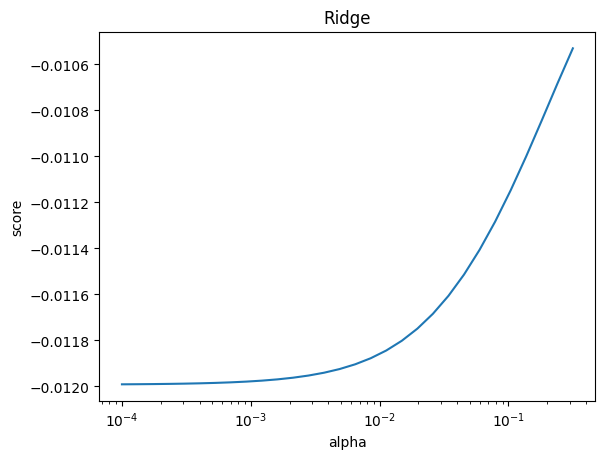

In [17]:
# Ridge Regression (L2)

ridge = Ridge(random_state = 42, max_iter = 10000)
alphas = np.logspace(-4,-0.5,30)

tuned_parameters = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv = n_folds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(X_train, Y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ",clf.best_estimator_.coef_)
ridge = clf.best_estimator_
print("Ridge Best Estimator: ", ridge)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test, y_predicted_dummy)
print("Ridge MSE: ",mse)
print("-----------------------------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")

### Regularization 2: Lasso Regression

Lasso'nun Ridge'den farkı, formüldür. 

Lasso Regression formülü: mean square error + λ * |slope|

Feature selection yöntemi olarak Lasso kullanılabilir.

Lasso'nun Riddge'den farkı, gereksiz feature'lere yani gereksiz coef'lere 0 değeri atanır. Ridge de ise coef değerleri 0 yapılmaz, 0.001 gibi küçük değerler yapılır. Ama lasso'da direk 0 değeri atanır.

Eğer Lasso'da independet variable'nin karşılığı 0 ise bunun anlamı dependent variable'ye etkisi yoktur. Yani buradaki feature'leri kullanmamıza gerek yoktur anlamına gelir.

Eğer yüksek korelasyon değerine sahip feature'ler var ise Lasso içlerinden en önemli 1 tanesini kullanır ve diğerlerine 0 atıyor.

Lasso'da train veri seti ile arasında biraz bias oluşuyor ama varyans daha azdır. Overfitting'i önlemektedir.

❗Regularization yöntemlerinin asıl amacı overfitting'i önlemektir.

Lasso Coef:  [-0.01692687 -0.10976505 -0.11721736 -0.03064576  0.09866154 -0.01243765
  0.16495225  0.          0.00378698 -0.00505995 -0.         -0.
  0.07376033]
Lasso Best Estimator:  Lasso(alpha=0.0037065129109221566, max_iter=10000, random_state=42)
Lasso MSE:  0.016597127172690847
---------------------------------------------------------------


Text(0.5, 1.0, 'Lasso')

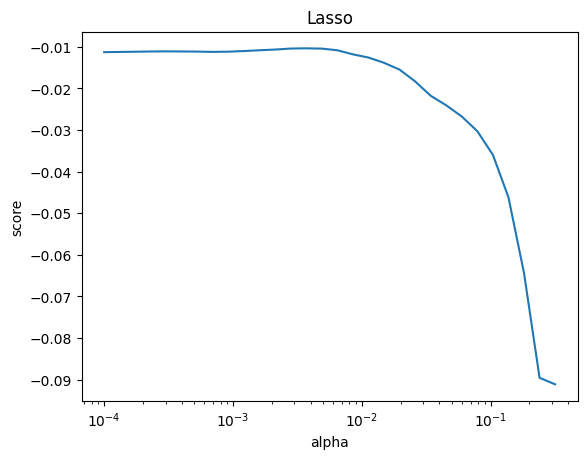

In [18]:
# Lasso Regression (L1)

lasso = Lasso(random_state=42, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error',refit=True)
clf.fit(X_train,Y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print("Lasso Coef: ",clf.best_estimator_.coef_)
lasso = clf.best_estimator_
print("Lasso Best Estimator: ",lasso)

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Lasso MSE: ",mse)
print("---------------------------------------------------------------")

plt.figure()
plt.semilogx(alphas, scores)
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")

Çıktıda


Lasso Coef:  [-0.01692687 -0.10976505 -0.11721736 -0.03064576  0.09866154 -0.01243765
  0.16495225  0.          0.00378698 -0.00505995 -0.         -0.
  
  kısmında görüldüğü üzere Lasso gereksiz olan features'lere direk 0 değerini atamaktadır.

### Regularization 3: ElasticNet

ElasticNet'te mean square error'u minimize etmeye çalışır. λ * (slope^2)'yi minimize etmeye çalışır. λ * |slope| 'yi minimize etmeye çalışır. Yani ElasticNet, hem Lasso hem de Ridge'nin kuvvetli yönlerine sahiptir.

ElasticNet = mse + (λ * (slope^2)) + (λ * |slope|)

In [19]:
# ElasticNet
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
clf.fit(X_train, Y_train)


print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("ElasticNet Best Estimator: ",clf.best_estimator_)


y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [-0.0518437  -0.10923982 -0.09538543 -0.03946691  0.09541227 -0.07791667
  0.14374215  0.          0.         -0.01852327 -0.         -0.00200172
  0.0793579 ]
ElasticNet Best Estimator:  ElasticNet(alpha=0.014873521072935119, l1_ratio=0.15000000000000002,
           max_iter=10000, random_state=42)
ElasticNet MSE:  0.017234676963922273


Sonuçlar şu şekildedir:

StandardScaler
  
    Linear Regression MSE:  0.020632204780133015
    
    Ridge MSE:  0.019725338010801216
    
    Lasso MSE:  0.017521594770822522
    
    ElasticNet MSE:  0.01749609249317252

RobustScaler:
    
    Linear Regression MSE:  0.020984711065869643
    
    Ridge MSE:  0.018839299330570554
    
    Lasso MSE:  0.016597127172690837
    
    ElasticNet MSE:  0.017234676963922273  

### XGBoost

XGBoost, büyük ve karmaşık veri setleri için dizayn edilmiş bir algoritmadır.

<br>
<img src="a5.png" align="left" style="width:300px;height:200px"/><br>   

Yukarıdaki problemi çözmek için bazı adımlar uygulayacağız.

İlk adım initial prediction'dur. İnitial prediction'u y=1 olarak yaptık. y=1'e bir line çizeriz. Bu line ile noktalar arasındaki residual'ları hesaplayacağız. -5, 5, 5, -3 residual değerleri elde edilmektedir.

quality hesaplayacağız. Bunu hesaplamak için residual değerlerini toplayıp elde edilen sonucun karesi alınır ve "residual sayısı + lambda" değerine böleriz. quality değerini 1 buluruz.

<br>
<img src="a6.png" align="left" style="width:600px;height:200px"/><br>   

Quality'i hesapladıktan sonra leaf'lere yani yapraklara geçeriz. Bunları hesaplayabilmek için x<4'ten ayıralım. x<4 e göre residual'lar yapraklara ayrılır. Bu işlemin ardından tekrar quality hesaplanır. Sonra da elde edilen tree'nin gain değeri hesaplanır.  

Gain = left + right - root

x<4 için gain değeri 40'tır.

Sonra tekrar ağaç yapısı oluşturulur. Root'taki değerler değişmez. x<7 için yeni ağaç oluşturulur. Sonra x<12 için yeni ağaç oluşturulur.

Artık başka line çizip ağaç oluşturmaya gerek yoktur. Çünkü bir line dah açekince biraz öncekinin aynısı elde edilir.Tüm residual'lar tek bir tarafa toplanır ve yaprakların sağ tarafı boş kalmış olur. Bu nedenle böyle bir tree design etmeyiz.

Elde edilen tree ler içerisinde en yüksek gain'e sahip olan x<4 ağacıdır. Bu ağacı ele alarak daha derine inmeye çalışırız.

Gerçekleştirilen tüm bu işlemler aşağıda görüldüğü gibidir:

<br>
<img src="a7.png" align="left" style="width:800px;height:400px"/><br>   

In [20]:
# %% XGBoost
parametersGrid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

clf.fit(X_train, Y_train)
model_xgb = clf.best_estimator_

y_predicted_dummy = clf.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[17:49:18] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBRegressor MSE:  0.017444718427058307


### Modellerin Ortalaması (Averaging Models)

Modellerin oratalaması alınacaktır. Yapılan prediction'ların ortalamasını alarak test score'yi elde edeceğiz. XGBoost ve Lasso'nun ortalamasını alacağız.

In [21]:
# %% Averaging Models

class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)  


averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(X_train, Y_train)

y_predicted_dummy = averaged_models.predict(X_test)
mse = mean_squared_error(Y_test,y_predicted_dummy)
print("Averaged Models MSE: ",mse)

[17:49:18] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Averaged Models MSE:  0.015753524420134286


En iyi sonuçları standart scaler'dense Robust Scaler'de alıyoruz.

Elde edilen sonuçlar aşağıdaki gibidir:

StandardScaler:
  
    Linear Regression MSE:  0.020632204780133015
    
    Ridge MSE:  0.019725338010801216
    
    Lasso MSE:  0.017521594770822522
    
    ElasticNet MSE:  0.01749609249317252
    
    XGBRegressor MSE: 0.017167257713690008
    
    Averaged Models MSE: 0.016034769734972223

RobustScaler:
    
    Linear Regression MSE:  0.020984711065869643
    
    Ridge MSE:  0.018839299330570554
    
    Lasso MSE:  0.016597127172690837
    
    ElasticNet MSE:  0.017234676963922273
    
    XGBRegressor MSE: 0.01753270469361755
    
    Averaged Models MSE: 0.0156928574668921
    
Lasso ve XGBoost'u birleştirerek ve bunların ortalamalarını alarak en iyi mean square error değerini elde ettik.

Projenin bitimi ile elde edilen sonuçlar aşağıda gördüğünüz gibidir:

<br>
<img src="a8.png" align="left" style="width:800px;height:400px"/><br>   